# Auto Regressive (AR) Model from scratch in Python

## Description

The following notebook contains an AR model that tries to lock onto a signal. 

It tries to predict the next sample given the previous "p" ones, where p is the order of the model.

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

## Importing the dataset

Select one of the datasets in the list: 
- n = 0: 'daily-min-temperatures.csv'
- n = 1: 'daily-total-female-births.csv'
- n = 2: 'monthly-sunspots.csv'
- n = 3: 'shampoo.csv'
- n = 4: DEBUG: simple line at 45 degree (used to debug as all coeffifients should be equal and equal to 1/model_order)

In [2]:
n = 4

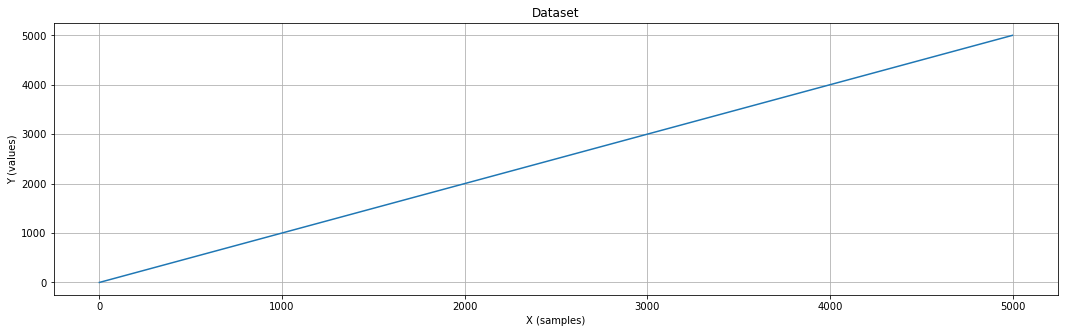

In [3]:
# Importing the dataset
if (n == 4):
    x = np.array([i for i in range(0, 5000)]) # Create a line
else:
    name = ['daily-min-temperatures.csv','daily-total-female-births.csv', 'monthly-sunspots.csv', 'shampoo.csv']
    header = ["Temp", "Births", "Sunspots", "Sales"]
    series = read_csv("datasets/" + name[n], header=0, index_col=0)
    x = np.array(series[header[n]])

# Plotting the data
plt.figure(figsize=(18,5))

plt.plot(x)

plt.title("Dataset")
plt.xlabel("X (samples)")
plt.ylabel("Y (values)")

plt.grid()
plt.show()

## Defining the AR model from scratch

This function implements an AR Model of order "p" with the following parameters:
 - lr: learning rate
 - p: model order
 - max_iter: maximum number of iterations to try to minimize the error

In [4]:
def AR(x, lr, p,  max_iter, detrend, verbose = False):
    
    """
    AR Model of order p
    - lr: learning rate
    - p: model order
    - max_iter: maximum number of iterations to try to minimize the error
    """
    
    # It can be helpful to remove the mean value of the time series
    if detrend == True:
        x = x - np.mean(x)

    # Initialize weights
    w = [1 for i in range(p)] 
    coef_history = []
    
    # Initialize error vector
    error_vector = [] 
    pred_vector = []

    # Compute the maximum number of iterations that can be done during training
    if max_iter > len(x):
        max_iter = len(x) - (p+1) 
        if (verbose == True):
            print("The maximum number of iterations considering the length of the array is:", max_iter, "\n") 
    
    # Training phase
    for i in range(max_iter):
        
        # Saving the history of the weights (coefficients of the AR model)
        coef_history.append([w[j] for j in range(p)])
        
        # Making the prediction (as the sum of weights*time_series)
        y_pred = 0
        for j in range(p):
            y_pred += w[j]*x[i-j+p]
        pred_vector.append(y_pred)
        
        # Computing the one step error (as the sum of squared errors: SSE)
        error = (x[i+1+p] - y_pred)**2  
        error_vector.append(error)
        
        # Update weights "w" using gradient descent as supposing the error stated before
        for j in range(p):
            w[j] = w[j] - lr*2*(x[i+1+p]-y_pred)*(-x[i-j+p])
    
    return error_vector, pred_vector, w, coef_history

## Model Settings

In [5]:
# Setting the model order "p"
model_order = 5
lr = 1e-09
max_iter = 99999

## Using the Auto Regressive model to see if it can follow the data

In the following cell the model has been used setting the order p to 5. This means that the model uses only the last 5 values of the time series to try to predict the next one. 

In this way the model produces an output that tries to lock on the signal. Below it can be seen how fast the code has executed on a 2012 i7 Mac Mini using Jupyter Lab on Anaconda Navigator

In [6]:
%%time

# Using the AR model and saving some parameters
error_vector, pred_vector, w, coef_history = AR(x, lr=lr, p=model_order, max_iter=max_iter , detrend = False, verbose=True)

The maximum number of iterations considering the length of the array is: 4994 

CPU times: user 250 ms, sys: 8.86 ms, total: 259 ms
Wall time: 258 ms


## Plotting the saved parameters


MSE (Mean Squared Error) of the last 5 steps (averaged) of the training phase rounded to two decimal places: 0.0 



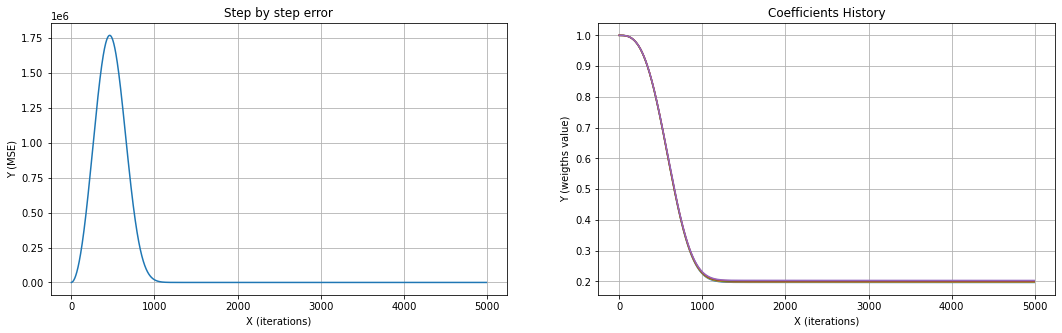

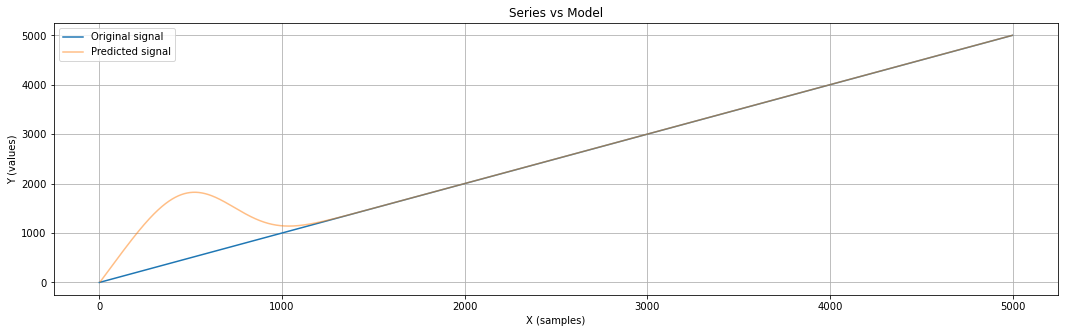

In [7]:
# Printing some metrics
#print("The best model coefficients for this time series are: \n", w)
print("\nMSE (Mean Squared Error) of the last 5 steps (averaged) of the training phase rounded to two decimal places:", np.around(np.mean(np.sqrt(error_vector[-5:])), 2), "\n")

# ==============================================================
# Plotting graphs

figure, ax = plt.subplots(nrows = 1, ncols=2, figsize=(18,5))

# Plotting a figure displaying how the error changes over time
ax[0].plot(error_vector)
ax[0].set_title("Step by step error")
ax[0].set_xlabel("X (iterations)")
ax[0].set_ylabel("Y (MSE)")
ax[0].grid()

# Plotting a figure displaying how the error changes over time
ax[1].plot(coef_history)
ax[1].set_title("Coefficients History")
ax[1].set_xlabel("X (iterations)")
ax[1].set_ylabel("Y (weigths value)")
ax[1].grid()

plt.show()

# ==============================================================
# Plotting how to model locks onto the signal (it predicts only the next sample given the previous "p" ones)

plt.figure(figsize=(18,5))
plt.title("Series vs Model")

plt.plot(x, label="Original signal")
y = np.arange(model_order,len(pred_vector)+model_order,1)
plt.plot(y, pred_vector, alpha = 0.5, label="Predicted signal")

plt.legend()
plt.xlabel("X (samples)")
plt.ylabel("Y (values)")
plt.grid()
plt.show()

## Using the Auto Regressive model to see if the model can predict recursively from its own produced data

Now we can try to see if the model is able to predict more than one sample recursively, even though the model coefficients have been se to minimize the MSE of only the next sample prediction, so it is not the task for which it has been trained to do, but it might be interesting to see. We should expect the error to worsen as the predictions move away from the last real value of the time series as the error propagates

This presumably works only if the coefficients converge to a constant value after training

The maximum number of iterations considering the length of the array is: 3744 


MSE (Mean Squared Error) of the last 5 steps (averaged) of the training phase rounded to two decimal places: 0.01 



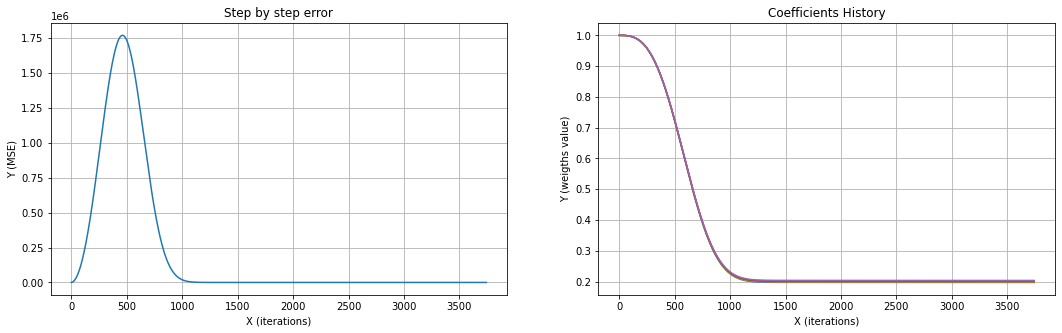

In [8]:
# Defining the dataset
training_set_percentage = 0.75 # Percentage of the time series used as training data (modify only this)
test_set_percentage = 1 - training_set_percentage # Percentage of the time series used as test data (this one automatically adapts from the training percentage)

# Computing the number of samples for the training phase
n_samples_training = np.ceil(training_set_percentage*len(x)).astype("int")
n_samples_test = len(x) - n_samples_training

# ==============================================================
# Using the AR model and saving some parameters
error_vector, pred_vector, w, coef_history = AR(x[:n_samples_training], lr=lr, p=model_order, max_iter=max_iter , detrend = False, verbose=True)

# Printing some metrics
#print("The best model coefficients for this time series are: \n", w)
print("\nMSE (Mean Squared Error) of the last 5 steps (averaged) of the training phase rounded to two decimal places:", np.around(np.mean(np.sqrt(error_vector[-5:])), 2), "\n")

# ==============================================================
# Plotting graphs

figure, ax = plt.subplots(nrows = 1, ncols=2, figsize=(18,5))

# Plotting a figure displaying how the error changes over time
ax[0].plot(error_vector)
ax[0].set_title("Step by step error")
ax[0].set_xlabel("X (iterations)")
ax[0].set_ylabel("Y (MSE)")
ax[0].grid()

# Plotting a figure displaying how the error changes over time
ax[1].plot(coef_history)
ax[1].set_title("Coefficients History")
ax[1].set_xlabel("X (iterations)")
ax[1].set_ylabel("Y (weigths value)")
ax[1].grid()

plt.show()

In [9]:
# Recursively make the prediction

# I take the last samples of the training data as a primer to start make new predictions recursively
new_data = x[n_samples_training - model_order: n_samples_training ]

for i in range(n_samples_test):
    prediction = np.sum(w*new_data[-model_order:])
    new_data = np.append(new_data, prediction)

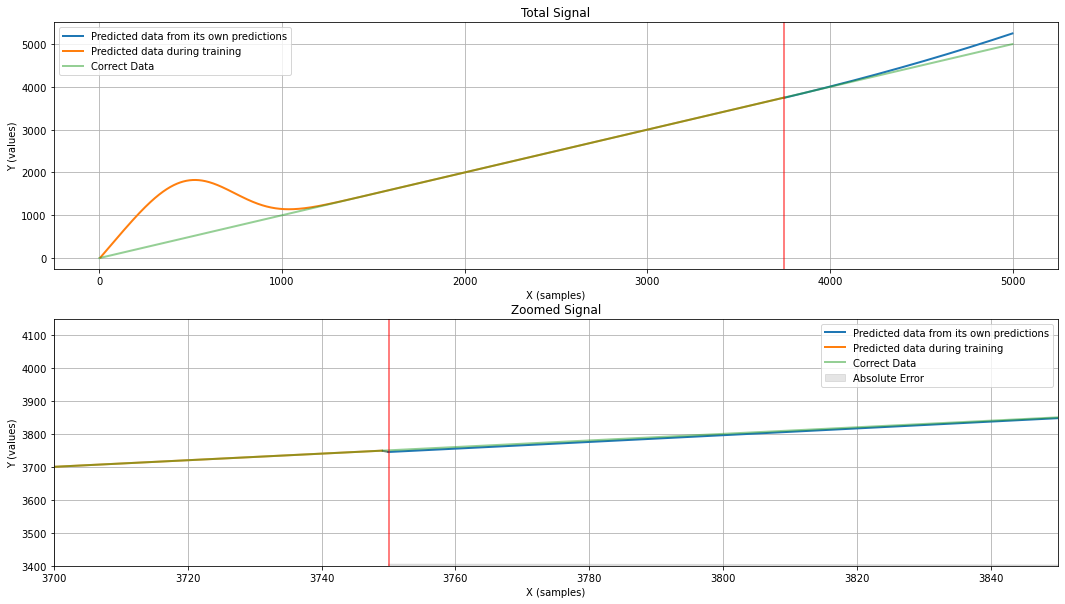

In [10]:
# Plotting the recursive predictions

figure, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(18,10))

# Total signal
ax[0].plot(np.arange(n_samples_training, n_samples_training+n_samples_test, 1), new_data[:n_samples_test], lw = 2, label="Predicted data from its own predictions")
ax[0].plot(np.arange(model_order+1, len(pred_vector)+model_order+1, 1), pred_vector, lw = 2, label="Predicted data during training")
ax[0].plot(np.arange(n_samples_training-1, n_samples_training+1, 1), [pred_vector[-1], new_data[0]], linestyle="dashed", lw=2, alpha=0.5, color="#000") #To graphically connect the two plots
ax[0].plot(x, alpha = 0.5, lw =2, label="Correct Data")
ax[0].axvline(n_samples_training, color="red", alpha = 0.5, lw=2)
ax[0].grid()
ax[0].legend()
ax[0].set_title("Total Signal")
ax[0].set_xlabel("X (samples)")
ax[0].set_ylabel("Y (values)")


# Zoomed signal around the end of the training phase
zoom_min = 50
zoom_max = 100

ax[1].plot(np.arange(n_samples_training, n_samples_training+n_samples_test, 1), new_data[:n_samples_test], lw = 2, label="Predicted data from its own predictions")
ax[1].plot(np.arange(model_order+1, len(pred_vector)+model_order+1, 1), pred_vector, lw = 2, label="Predicted data during training")
ax[1].plot(np.arange(n_samples_training-1, n_samples_training+1, 1), [pred_vector[-1], new_data[0]], linestyle="dashed", lw=2, alpha=0.5, color="#000") #To graphically connect the two plots
ax[1].plot(x, alpha = 0.5, lw =2, label="Correct Data")
ax[1].axvline(n_samples_training, color="red", alpha = 0.5, lw=2)
ax[1].grid()

ax[1].set_xlim(n_samples_training-zoom_min, n_samples_training+zoom_max)

y_min = min(x[n_samples_training-zoom_min: n_samples_training+zoom_max]) - 300
y_max = max(x[n_samples_training-zoom_min: n_samples_training+zoom_max]) + 300
ax[1].set_ylim(y_min, y_max)

# Displaying the absolute error in the zoomed plot between the true and the recursively predicted time series
error_plot = np.abs(x[n_samples_training : n_samples_training+n_samples_test] - new_data[:n_samples_test])
ax[1].fill_between(np.arange(n_samples_training, n_samples_training+n_samples_test, 1), error_plot+y_min, y_min, alpha = 0.2, color="gray", label="Absolute Error")

ax[1].legend()
ax[1].set_title("Zoomed Signal")
ax[1].set_xlabel("X (samples)")
ax[1].set_ylabel("Y (values)")

plt.show()